In [1]:
# Python calculation for the example and exercise from Lecture 4 notes
import numpy as np
import os
import math
import pandas as pd
import scipy.stats as stat
import statistics
from statistics import NormalDist
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import scipy.integrate as integrate
import scipy.stats as stats


# Part 1 - Data Cleaning

In [2]:
ois = pd.read_excel("IR Data.xlsx", sheet_name="OIS", engine="openpyxl", usecols=[0,1,2])
ois.head(5)

,Tenor,Product,Rate
0,6m,OIS,0.00250
1,1y,OIS,0.00300
2,2y,OIS,0.00325
3,3y,OIS,0.00335
4,4y,OIS,0.00350


In [3]:
def convert_tenor_to_t(tenor:str):
    if tenor.endswith("y"):
        return int(tenor.removesuffix("y"));
    if tenor.endswith("m"):
        tenor = tenor.removesuffix("m")
        return int(tenor) * 30 / 360 # NOTE: based on day count 30/360 convention

In [ ]:
ois['T'] = ois['Tenor'].apply(convert_tenor_to_t)

for index, row in ois.iterrows():
    t_start = 0;
    if (index != 0):
        t_start = ois.iloc[index-1]['T']
    ois.at[index, 'T_start'] = float(t_start)
# ois["ois_discount_factor"] = ois.apply(lambda row: calc_ois_discount_factor(row["Rate"], 0, row["T"]), axis=1)

# Just to rearrange it 
col = ois.pop("T_start")
target_index = ois.columns.get_loc('T')
ois.insert(target_index, "T_start", col)
ois.head(5)


,Tenor,Product,Rate,T_start,T
0,6m,OIS,0.00250,0.0,0.5
1,1y,OIS,0.00300,0.5,1.0
2,2y,OIS,0.00325,1.0,2.0
3,3y,OIS,0.00335,2.0,3.0
4,4y,OIS,0.00350,3.0,4.0


## Calculating OIS Discount Factors

### Formulas below:


#### for calc_compounded_rate (idk what to call this): 
$\frac{1}{(1 + f/360) ** (360N)}$

#### calc_discount_factor_ois:
- this is mainly used compounded with previous discount factor

$DF_{\text{previous}} * \frac{1}{(1 + f/360) ** (360N)}$

In [5]:
def calc_compounded_rate(f, N):
    # f - overnight rate
    # N - number of years
    return 1 / ((1 + f/360) ** (360 * N))

def calc_discount_factor_ois(previous_discount_factor, f, N):
    # previous_discount_factor
    # f - overnight rate
    # N - number of years for new overnight rate to compound
    return previous_discount_factor * calc_compounded_rate(f, N)

In [6]:
previous_flt_payouts = [] # this is used to easily calculate the previous flt_payouts 
previous_discount_factors = []

DF_name = "Discount Factor"

for index, row in ois.iterrows():
    f = -1 # temporary place holder
    current_discount_factor = -1
    if index == 0: 
        # T = 0.5
        f = ( (row['T'] * row['Rate'] + 1) ** (1/180) - 1 ) * 360
        current_discount_factor = calc_discount_factor_ois(1, f, 0.5) # no previous discount factor, set to 1 for multiplying
    elif index == 1: 
        # T = 1;
        first_row = ois.iloc[0]

        # note: discount_factor Do(0,1Y) is not here because its cancelled out, so no need to include, actually can just manually rearrange
        f = fsolve(
            lambda f:
               ( (1 + first_row['f']/360) ** 180 ) * ( (1 + f/360) ** 180) # PV flt
               - 1.003 # PV fix 
            ,
            x0 = first_row['f']
            )

        current_discount_factor = calc_discount_factor_ois(first_row[DF_name], f, 0.5);
        current_flt_payout = current_discount_factor * (( ((1 + first_row['f']/360) ** 180) * ((1 + f/360)** 180)) - 1 )

        # saving it to use later
        previous_flt_payouts.append(current_flt_payout)
        previous_discount_factors.append(current_discount_factor)
    else:
        previous_row = ois.iloc[index-1];
        N = row['T'] - previous_row['T']
        # fsolve is trying to find overnight rate f -> using 0 = PV_flt - PV_fix
        f = fsolve(
            lambda f: 
            np.sum(previous_flt_payouts) + calc_discount_factor_ois(previous_row[DF_name], f, N) * ((1 + f/360) ** (360 * N) - 1) # pv of flt = sum of previous flt payout + current flt payout 
            - (np.sum(previous_discount_factors) + calc_discount_factor_ois(previous_row[DF_name], f, N)) * row['Rate'], # pv of fix = [sum of previous discount factor + current discount factor] * ois_par_swap_rate
            x0= previous_row['f']
        )
        
        current_discount_factor = calc_discount_factor_ois(previous_row[DF_name], f, N)
        current_flt_payout = current_discount_factor * ((1 + f/360) ** (360 * N) - 1)

        previous_flt_payouts.append(current_flt_payout)
        previous_discount_factors.append(current_discount_factor)

    ois.at[index, 'f'] = f;
    ois.at[index,DF_name] = current_discount_factor
ois

,Tenor,Product,Rate,T_start,T,f,Discount Factor
0,6m,OIS,0.00250,0.0,0.5,0.002498,0.998752
1,1y,OIS,0.00300,0.5,1.0,0.003493,0.997009
2,2y,OIS,0.00325,1.0,2.0,0.003495,0.993531
3,3y,OIS,0.00335,2.0,3.0,0.003545,0.990015
4,4y,OIS,0.00350,3.0,4.0,0.003946,0.986117
5,5y,OIS,0.00360,4.0,5.0,0.003996,0.982184
6,7y,OIS,0.00400,5.0,7.0,0.003005,0.976299
7,10y,OIS,0.00450,7.0,10.0,0.002510,0.968976
8,15y,OIS,0.00500,10.0,15.0,0.001710,0.960726
9,20y,OIS,0.00525,15.0,20.0,0.001456,0.953755


In [7]:
### copied from Brandon's code

# Interpolate for 0.5y periods
tenor_intervals = np.arange(0.5, 20.5, 0.5)  # 0.5, 1.0, 1.5, ..., 10.0
rate_interp = interp1d(ois["T"], ois["Rate"], kind='linear', fill_value="extrapolate")
df_interp = interp1d(ois["T"], ois[DF_name], kind='linear', fill_value="extrapolate")

interpolated_rates = rate_interp(tenor_intervals)
interpolated_dfs = df_interp(tenor_intervals)

ois_discount_factors = pd.DataFrame({
    'Tenor': tenor_intervals,
    'Rate': interpolated_rates,
    DF_name: interpolated_dfs
})

ois_discount_factors

,Tenor,Rate,Discount Factor
0,0.5,0.002500,0.998752
1,1.0,0.003000,0.997009
2,1.5,0.003125,0.995270
3,2.0,0.003250,0.993531
4,2.5,0.003300,0.991773
5,3.0,0.003350,0.990015
6,3.5,0.003425,0.988066
7,4.0,0.003500,0.986117
8,4.5,0.003550,0.984150
9,5.0,0.003600,0.982184


## CMS Rate calculation (from project notes)
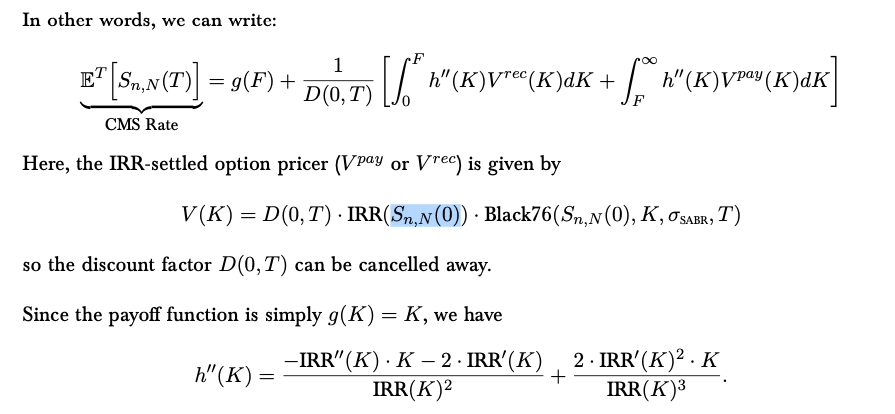


In [8]:
##### From Prof's cms_replication.ipynb


def IRR_0(K, N, m=2):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, N, m=2):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, N, m=2):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative


def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

def h_0(K, N, m=2):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, N, m=2):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, N, m=2):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

We will also need to implement the IRR-settled payer and receiver swaption formulae:
$$
  \begin{equation*}
    \begin{split}
      V^{pay}_{n,N}(0) &= D(0,T_n) \cdot \text{IRR}(S_{n,N}(0)) \cdot \text{Black76Call}(S_{n,N}(0),K,\sigma_{n,N},T) \\
      V^{rec}_{n,N}(0) &= D(0,T_n) \cdot \text{IRR}(S_{n,N}(0)) \cdot \text{Black76Put}(S_{n,N}(0),K,\sigma_{n,N},T) \\
    \end{split}
  \end{equation*}
$$
where $S_{n,N}(0)=F$ is today's forward swap rate calculated based on the curves we bootstrapped, and $\sigma_{n,N}$ is the SABR implied volatility calibrated to swaption market data.|

In [9]:
def calc_black_model_d1(F: float, K: float, sigma: float, T: float) -> float:
    sigma_sqrt_time = sigma * np.sqrt(T)
    num1 = np.log(F / K)
    num2 = 0.5 * np.power(sigma, 2) * T
    return ( num1 + num2 ) / sigma_sqrt_time

def calc_black_model_d2(F: float, K: float, sigma: float, T: float) -> float:
    sigma_sqrt_time = sigma * np.sqrt(T)
    d1 = calc_black_model_d1(F, K, sigma, T)
    return d1 - sigma_sqrt_time

def BlackCall(F: float, K: float, sigma: float, T: float) -> float:
    d1 = calc_black_model_d1(F, K, sigma, T)
    d2 = calc_black_model_d2(F, K, sigma, T)
    return (F * stats.norm.cdf(d1) - K * stats.norm.cdf(d2))

def BlackPut(F: float, K: float,  sigma: float, T: float) -> float:
    d1 = calc_black_model_d1(F, K, sigma, T)
    d2 = calc_black_model_d2(F, K, sigma, T)
    return (K * stats.norm.cdf(-d2) - F * stats.norm.cdf(-d1))

In [12]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [46]:
def calculate_discount_factor(rate, tenor, compounding=2):
    """
    Calculate the discount factor for a given rate, tenor, and compounding frequency.
    """
    return 1 / (1 + rate / compounding) ** (compounding * tenor)

def convert_tenor(tenor):
    if "m" in tenor:
        return int(tenor.replace("m", "")) / 12  # Convert months to years
    elif "y" in tenor:
        return int(tenor.replace("y", ""))
    return None


def calculate_forward_swap_rate(tenor_start, tenor_end, fwd_strikes, compounding=2):
    """
    Calculate the forward swap rate for a swap starting at tenor_start and ending at tenor_end.

    Parameters:
        tenor_start (float): Start of the swap (in years).
        tenor_end (float): End of the swap (in years).
        irs_rates (dict): Dictionary of IRS rates for different tenors.
        compounding (int): Compounding frequency per year (default is 2 for semi-annual).

    Returns:
        float: Forward swap rate.
    """
    # Extract tenors and rates from the DataFrame
    fwd_strikes["Tenor_Years"] = fwd_strikes["Tenor"].apply(convert_tenor)
    tenors = fwd_strikes['Tenor_Years']
    rates = fwd_strikes['Rate'].values

    # Create an interpolation function for the rates
    interp_func = interp1d(tenors, rates, kind='linear', fill_value="extrapolate")

    rate_start = interp_func(tenor_start)
    rate_end = interp_func(tenor_end)

    # Get discount factors
    disc_start = calculate_discount_factor(rate_start, tenor_start, compounding)
    disc_end = calculate_discount_factor(rate_end, tenor_end, compounding)

    # Calculate the sum of discount factors for the swap period
    sum_disc = 0
    t = tenor_start + 0.5
    while t < tenor_end:
        sum_disc += 0.5 * calculate_discount_factor(rate_end, t, compounding)
        t += 0.5

    # Calculate forward swap rate
    forward_rate = (disc_start - disc_end) / sum_disc
    return forward_rate

fwd_strikes = pd.read_excel("IR Data.xlsx", sheet_name = 'IRS' , engine = "openpyxl", usecols = [0,1,2])

# Define expiries and tenors
expiries = [1, 5, 10]  # Row indices (expiry in years)
tenors = [1, 2, 3, 5, 10]  # Column indices (tenor in years)

# Initialize the forward swap rate matrix
forward_swap_matrix = np.zeros((len(expiries), len(tenors)))

# Calculate forward swap rates for each expiry and tenor
for i, expiry in enumerate(expiries):
    for j, tenor in enumerate(tenors):
        tenor_start = expiry
        tenor_end = expiry + tenor
        forward_swap_matrix[i, j] = calculate_forward_swap_rate(tenor_start, tenor_end, fwd_strikes)

# Convert the matrix to a DataFrame for better visualization
forward_swap_df = pd.DataFrame(forward_swap_matrix, index=[f"{e}Y" for e in expiries], columns=[f"{t}Y" for t in tenors])
forward_swap_df.index.name = "Expiry"
forward_swap_df.columns.name = "Tenor"

# Print the forward swap rate matrix
print(forward_swap_df)

Tenor         1Y        2Y        3Y        5Y       10Y
Expiry                                                  
1Y      0.063563  0.044052  0.040556  0.038900  0.040431
5Y      0.077459  0.053087  0.047993  0.045576  0.046178
10Y     0.086543  0.058661  0.053672  0.051339  0.057526


In [47]:
sabr_alpha = pd.read_excel("sabr_calibrated.xlsx", sheet_name="sabr_alpha", engine="openpyxl", index_col=0)
sabr_rho = pd.read_excel("sabr_calibrated.xlsx", sheet_name="sabr_rho", engine="openpyxl", index_col=0)
sabr_nu = pd.read_excel("sabr_calibrated.xlsx", sheet_name="sabr_nu", engine="openpyxl", index_col=0)

sabr_alpha


,1Y,2Y,3Y,5Y,10Y
1Y,0.139080,0.184661,0.197052,0.178169,0.171272
5Y,0.166992,0.199889,0.210471,0.189860,0.174659
10Y,0.177315,0.195506,0.208011,0.204190,0.182048


In [48]:
expiry_range = np.arange(0.25,10.25, 0.25) # 0.25, 0.5, 0.75, ..., 10

## interpolate sabr
def interpolate_df(df):
    # reindex so that can use to interpolate
    df.index = df.index.str.replace('Y','').astype(float)

    one_year_interp = interp1d(df.index, df['1Y'], kind='linear', fill_value="extrapolate" )
    two_year_interp = interp1d(df.index, df['2Y'], kind='linear', fill_value="extrapolate" )
    three_year_interp = interp1d(df.index, df['3Y'], kind='linear', fill_value="extrapolate" )
    five_year_interp = interp1d(df.index, df['5Y'], kind='linear', fill_value="extrapolate" )
    ten_year_interp = interp1d(df.index, df['10Y'], kind='linear', fill_value="extrapolate" )
    return pd.DataFrame({
    '1Y': one_year_interp(expiry_range),
    '2Y': two_year_interp(expiry_range),
    '3Y': three_year_interp(expiry_range),
    '5Y': five_year_interp(expiry_range),
    '10Y': ten_year_interp(expiry_range)
    }, index=expiry_range)
    
    
sabr_alpha_interp = interpolate_df(sabr_alpha)
sabr_rho_interp = interpolate_df(sabr_rho)
sabr_nu_interp = interpolate_df(sabr_nu)
forward_swap_df_interp = interpolate_df(forward_swap_df)

In [49]:
forward_swap_df_interp.head(5)

,1Y,2Y,3Y,5Y,10Y
0.25,0.060957,0.042358,0.039162,0.037649,0.039354
0.50,0.061826,0.042923,0.039627,0.038066,0.039713
0.75,0.062694,0.043487,0.040091,0.038483,0.040072
1.00,0.063563,0.044052,0.040556,0.038900,0.040431
1.25,0.064431,0.044617,0.041021,0.039318,0.040790


In [61]:
### eventually D(0,T) cancels away so we have

def calc_cms_rate(
        F: float,  #forward swap rate
        N: float, # should be the tenor?
        T: float, # 
        sabr_alpha: float,
        sabr_rho: float,
        sabr_nu: float
):
    # def SABR(F, K, T, alpha, beta, rho, nu):
    # 
    sabr_beta = 0.9

    integrand_receiver = lambda k: h_2(K=k, N=N) * IRR_0(F, N) * BlackPut(F, k, SABR(F, k, T, sabr_alpha, sabr_beta, sabr_rho, sabr_nu), T)
    receiver_part, error = integrate.quad(integrand_receiver, 0, F)
    print(f"receiver error: {error}" )

    integrand_payer = lambda k: h_2(K=k, N=N) * IRR_0(F, N) * BlackCall(F, k, SABR(F, k, T, sabr_alpha, sabr_beta, sabr_rho, sabr_nu), T)
    payer_part, error = integrate.quad(integrand_payer, F, np.inf)
    print(f"payer error: {error}" )

    return g_0(F) + receiver_part + payer_part

In [62]:
# Expectation of a S_{6m,10y6m}(6m)
forward_swap_rate = forward_swap_df_interp.loc[0.5]['10Y']
sabr_alpha_val = sabr_alpha_interp.loc[0.5]['10Y']
sabr_rho_val = sabr_rho_interp.loc[0.5]['10Y']
sabr_nu_val = sabr_nu_interp.loc[0.5]['10Y']

calc_cms_rate(F=forward_swap_rate, 
              N=10, 
              T=0.5, 
              sabr_alpha=sabr_alpha_val,
              sabr_rho=sabr_rho_val,
              sabr_nu=sabr_nu_val
              )

receiver error: 9.562947341548505e-10
payer error: 1.3301889064080177e-10


0.13174589859430777